In [1]:
import pandas as pd
import json
from datetime import datetime

### Xóa cột coefficient, language_id. Đổi tên cột assignment_id, problem_id, username

In [4]:

df = pd.read_csv(r'D:\DoAnMayHoc\score_regression\data\annonimized.csv')
df.rename(columns={
    "concat('it001',`assignment_id`)": 'assignment_id',
    "concat('it001',`problem_id`)": 'problem_id',
    "concat('it001', username)": 'username',
    "concat('it001',`language_id`)": 'language_id',
}, inplace=True)

df.drop(columns=['coefficient', 'language_id'], inplace=True)

df.to_csv(r'D:\DoAnMayHoc\score_regression\data\data_cleaned.csv', index=False)

### Lọc features

In [31]:
df = pd.read_csv(r'D:\DoAnMayHoc\score_regression\data\data_cleaned.csv')
df['created_at'] = df['created_at'].str.split().str[1]
df['updated_at'] = df['updated_at'].str.split().str[1]

df['created_at'] = pd.to_datetime(df['created_at'], format='%H:%M:%S')
df['updated_at'] = pd.to_datetime(df['updated_at'], format='%H:%M:%S')

# Sửa lỗi âm bằng cách giả sử updated_at hôm sau
df.loc[df['updated_at'] < df['created_at'], 'updated_at'] += pd.Timedelta(days=1)

# Tính thời gian
df['duration'] = (df['updated_at'] - df['created_at']).dt.total_seconds()/3600

# Tóm tắt theo user
df_summary = df.groupby('username').agg(
    total_submissions=('username', 'count'),
    total_problems=('problem_id', 'nunique'),
    total_assignments=('assignment_id', 'nunique'),
    total_score_status=('status', lambda x: (x == 'SCORE').sum()),
    avg_duration=('duration', 'mean')
).reset_index()

df_summary['avg_score_status'] = df_summary['total_score_status'] / df_summary['total_submissions']

df_summary['avg_submissions'] = df_summary['total_submissions'] / df_summary['total_problems']
df_summary.drop(columns=['total_score_status','total_submissions'], inplace=True)

max_values = df_summary[['total_problems', 'total_assignments']].max()
df_summary['total_problems'] = df_summary['total_problems'] / max_values['total_problems']
df_summary['total_assignments'] = df_summary['total_assignments'] / max_values['total_assignments']
df_summary.to_csv(r'D:\DoAnMayHoc\score_regression\data\user_feature.csv', index=False)



### Lọc file điểm qt

In [32]:
df_scores = pd.read_csv(r'D:\DoAnMayHoc\score_regression\data\qt-public.csv')
df = df_scores.dropna(subset=['diemqt'])
df.to_csv(r'D:\DoAnMayHoc\score_regression\data\qt\qt-public-cleaned.csv', index=False)

In [33]:
df_features = pd.read_csv(r'D:\DoAnMayHoc\score_regression\data\user_feature.csv') 
df_scores = pd.read_csv(r'D:\DoAnMayHoc\score_regression\data\qt\qt-public-cleaned.csv')
df_scores.rename(columns={'hash': 'username'}, inplace=True)

# 1. user_without_features: users có trong features nhưng không có trong scores
users_features = set(df_features['username'])
users_scores = set(df_scores['username'])

users_without_scores = users_features - users_scores  # tập user có trong features nhưng không trong scores

df_user_without_features = df_features[df_features['username'].isin(users_without_scores)]

# 2. user_with_features: users có trong cả 2 file, lưu toàn bộ cột (merge trên username)
df_user_with_features = pd.merge(df_scores, df_features, on='username', how='inner')

# Lưu ra file
df_user_without_features[['username']].to_csv(r'D:\DoAnMayHoc\score_regression\data\qt\user_without_features.csv', index=False)
df_user_with_features.to_csv(r'D:\DoAnMayHoc\score_regression\data\qt\user_with_features.csv', index=False)
df_user_with_features.isnull().sum()  # Kiểm tra có cột nào bị thiếu không
df_user_without_features.isnull().sum()

username             0
total_problems       0
total_assignments    0
avg_duration         0
avg_score_status     0
avg_submissions      0
dtype: int64

In [34]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Đọc file
df = pd.read_csv(r'D:\DoAnMayHoc\score_regression\data\qt\user_with_features.csv')

# Giả sử cột điểm cần dự đoán là 'diemqt'
target_col = 'diemqt'  # đổi theo cột điểm thực tế của bạn

# Lọc features: bỏ cột username và cột target
X = df.drop(columns=['username', 'diemqt'])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Khởi tạo và train model
model = LinearRegression()
model.fit(X_train, y_train)


# Dự đoán trên tập test
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f'R^2 Score: {r2:.4f}')



R^2 Score: 0.1228


In [37]:
# 1. Đọc dữ liệu
df_features = pd.read_csv(r'D:\DoAnMayHoc\score_regression\data\user_feature.csv') 
df_without_features = pd.read_csv(r'D:\DoAnMayHoc\score_regression\data\qt\user_without_features.csv')

df_to_predict = df_features[df_features['username'].isin(df_without_features['username'])].copy()

# Xác định các cột đặc trưng
feature_cols = ['total_problems','total_assignments','avg_duration','avg_score_status','avg_submissions']

# Dự đoán
df_to_predict['predicted_score'] = model.predict(df_to_predict[feature_cols])

# Làm tròn đến 0.5 và giới hạn tối đa là 10
df_to_predict['predicted_score'] = (df_to_predict['predicted_score'] * 2).round() / 2
df_to_predict['predicted_score'] = df_to_predict['predicted_score'].clip(upper=10)
df_to_predict[['username', 'predicted_score']].to_csv(r'D:\DoAnMayHoc\score_regression\data\qt\qt_submit_4.csv', index=False)



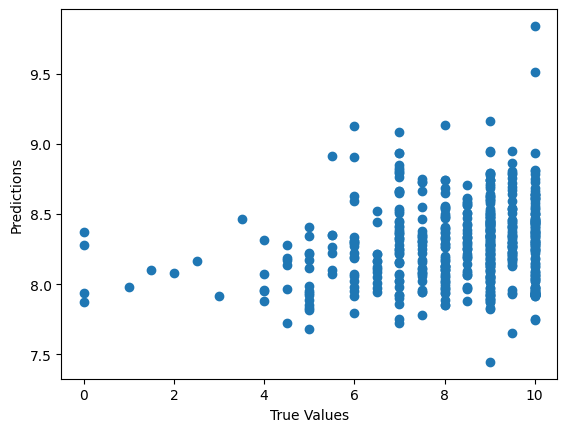

In [18]:
y_pred_train = model.predict(X_train)
import matplotlib.pyplot as plt
plt.scatter(y_train, y_pred_train)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()